In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 1. Load the full CFPB dataset with Dask
df = pd.read_csv('../Data/complaints.csv')


# 2. Filter to the five target Products to reduce the size of the data since collab keeps crashing
keep = [
    'Credit card',
    'Personal loan',
    'Buy Now, Pay Later (BNPL)',
    'Savings account',
    'Money transfers'
]
df = df[df['Product'].isin(keep)]

/tmp/ipython-input-2-456676068.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Copy of complaints.csv')


In [ ]:
print(df.head())                      
print(df.dtypes)                      
print(df.nunique())

    Date received      Product                                 Sub-product  \
334    2025-06-20  Credit card  General-purpose credit card or charge card   
595    2025-06-20  Credit card  General-purpose credit card or charge card   
661    2025-06-20  Credit card  General-purpose credit card or charge card   
687    2025-06-20  Credit card  General-purpose credit card or charge card   
795    2025-06-20  Credit card  General-purpose credit card or charge card   

                                                 Issue  \
334  Problem with a company's investigation into an...   
595  Problem with a company's investigation into an...   
661  Problem with a company's investigation into an...   
687  Problem with a company's investigation into an...   
795               Incorrect information on your report   

                                             Sub-issue  \
334  Was not notified of investigation status or re...   
595  Was not notified of investigation status or re...   
661  Was

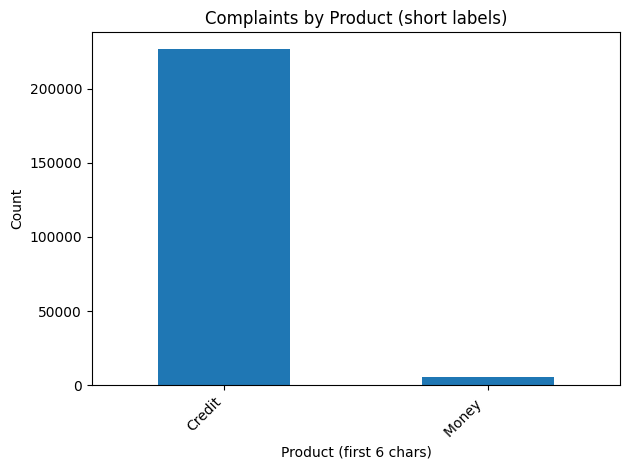

In [4]:
# 3. Analyze distribution of complaints across Products (6-char labels)
df['prod6'] = df['Product'].str.slice(0, 6)

# Plot using the truncated labels
df['prod6'].value_counts().plot(kind='bar')
plt.title('Complaints by Product (short labels)')
plt.xlabel('Product (first 6 chars)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


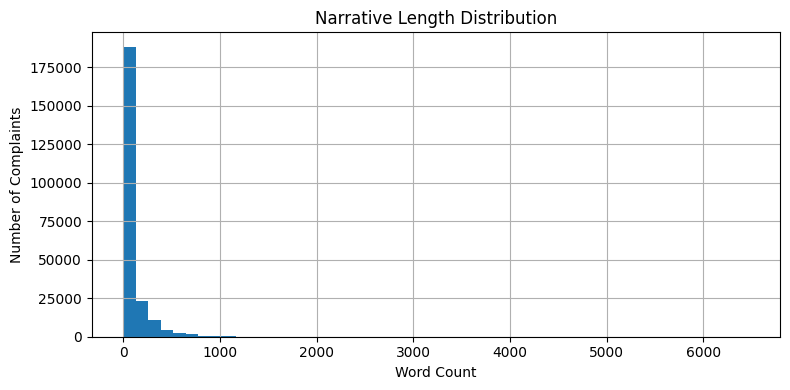

Shortest narratives (word counts):
334    0
595    0
661    0
687    0
795    0
Name: narr_len, dtype: int64

Longest narratives (word counts):
2946941    6469
3620187    5911
4022686    5910
8672702    5907
4023259    5900
Name: narr_len, dtype: int64


In [5]:

# 4. Narrative length distribution (word count)
#    first fill NAs, then count words
df['narr_len'] = df['Consumer complaint narrative']\
                    .fillna('')\
                    .str.split()\
                    .map(len)
# convert to pandas for plotting
narr = df['narr_len']
narr.hist(bins=50, figsize=(8,4))
plt.title('Narrative Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Number of Complaints')
plt.tight_layout()
plt.show()

#    identify very short / very long
short_idxs = narr.nsmallest(5).index
long_idxs  = narr.nlargest(5).index
print("Shortest narratives (word counts):")
print(narr.loc[short_idxs])
print("\nLongest narratives (word counts):")
print(narr.loc[long_idxs])


In [6]:

# 5. Count complaints with vs without narrative
num_empty = (narr == 0).sum()
num_total = len(narr)
print(f"Complaints WITHOUT narrative: {num_empty}")
print(f"Complaints WITH narrative: {num_total - num_empty}")


Complaints WITHOUT narrative: 149876
Complaints WITH narrative: 82164


In [ ]:

# 6. Drop any rows whose narrative is empty or null
df = df[df['Consumer complaint narrative'].notnull()]
df = df[df['Consumer complaint narrative'].str.strip() != '']


In [ ]:
# 7. Clean the text for better embeddings
def clean_text(text):
    text = text.lower()
    # remove common boilerplate
    text = re.sub(r'i am writing to (file|submit) a complaint[^\n]*', '', text)
    # strip out non-alphanumeric characters
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# if using Dask:
df['clean_narrative'] = df['Consumer complaint narrative'].map(clean_text)

In [ ]:
# 8. Recompute narrative length on cleaned text
df['clean_len'] = df['clean_narrative'].str.split().map(len)
clean_len = df['clean_len']
print("After cleaning narrative length stats:")
print(clean_len.describe())


After cleaning narrative length stats:
count    82164.000000
mean       201.368945
std        220.865719
min          0.000000
25%         64.000000
50%        143.000000
75%        263.000000
max       6472.000000
Name: clean_len, dtype: float64


In [10]:
len(df)
df.to_csv("filtered_complaints.csv")